# 气候观察者模型


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
import pandas as pd
import numpy as np

/Users/songshgeo/Documents/VSCode/past1000/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/songshgeo/Documents/VSCode/past1000/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[14:44:48][WARNING][datacollector] No final reporters have been definedreturning empty DataFrame.


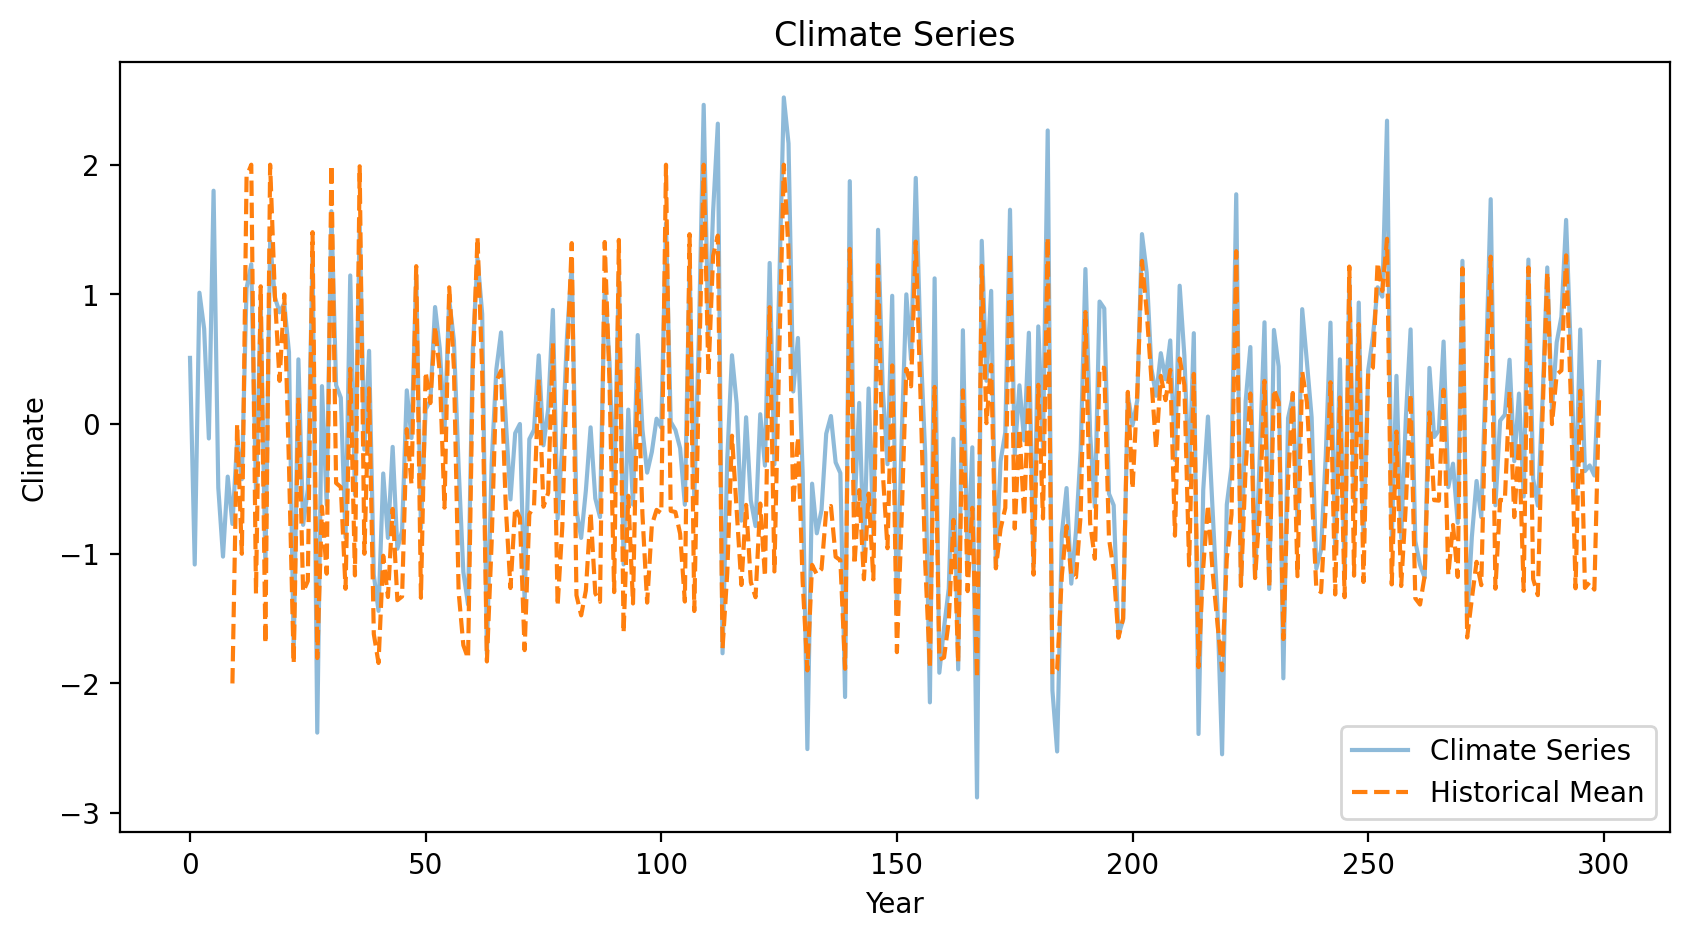

In [2]:
from past1000.abm import Model
import matplotlib.pyplot as plt

# 运行模型
parameters = {
    "years": 300,
    "max_age": 80,
    "loss_rate": 0.4,
    "new_agents": 5,
    "min_age": 10,
}
model = Model(parameters={"model": parameters})
model.run_model()

# 绘制气候序列和历史平均
historical_mean = pd.Series({k: np.mean(v) for k, v in model._archive.items()})
fig, ax = plt.subplots(figsize=(10, 5))
model.climate_series.plot(ax=ax, label="Climate Series", alpha=0.5)
historical_mean.plot(ax=ax, label="Historical Mean", linestyle="--")
ax.set_title("Climate Series")
ax.set_xlabel("Year")
ax.set_ylabel("Climate")
ax.legend()
plt.show();

/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_72239/1713306589.py:4: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  historical_mode = pd.Series({k: mode(v)[0] for k, v in model._archive.items()})


<Axes: title={'center': "Kappa: 0.78, Kendall's Tau: 0.85**"}, xlabel='Predicted label', ylabel='True label'>

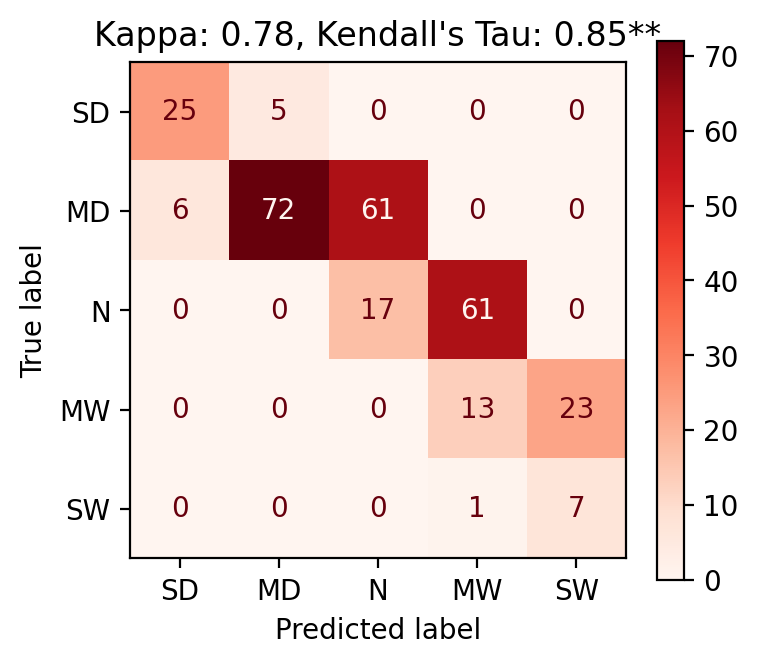

In [3]:
from scipy.stats import mode
from past1000.viz.plot import plot_confusion_matrix

historical_mode = pd.Series({k: mode(v)[0] for k, v in model._archive.items()})
classified = model.classified.copy()
plot_confusion_matrix(historical_mode, classified, dropna=True)

r_benchmark: 0.85578


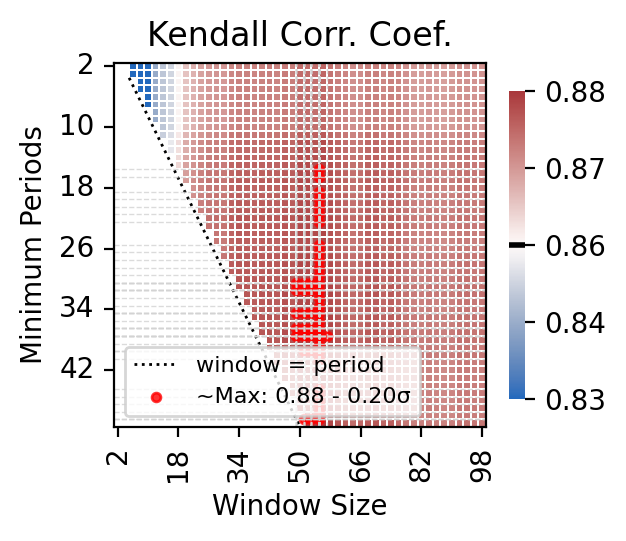

In [4]:
from past1000.compare import experiment_corr_2d
from past1000.filters import calc_std_deviation

filtered, r_benchmark, ax = experiment_corr_2d(
    historical_mean,
    model.climate_series,
    filter_func=calc_std_deviation,
    corr_method="kendall",
    filter_side="right",
)

/Users/songshgeo/Documents/VSCode/past1000/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/songshgeo/Documents/VSCode/past1000/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


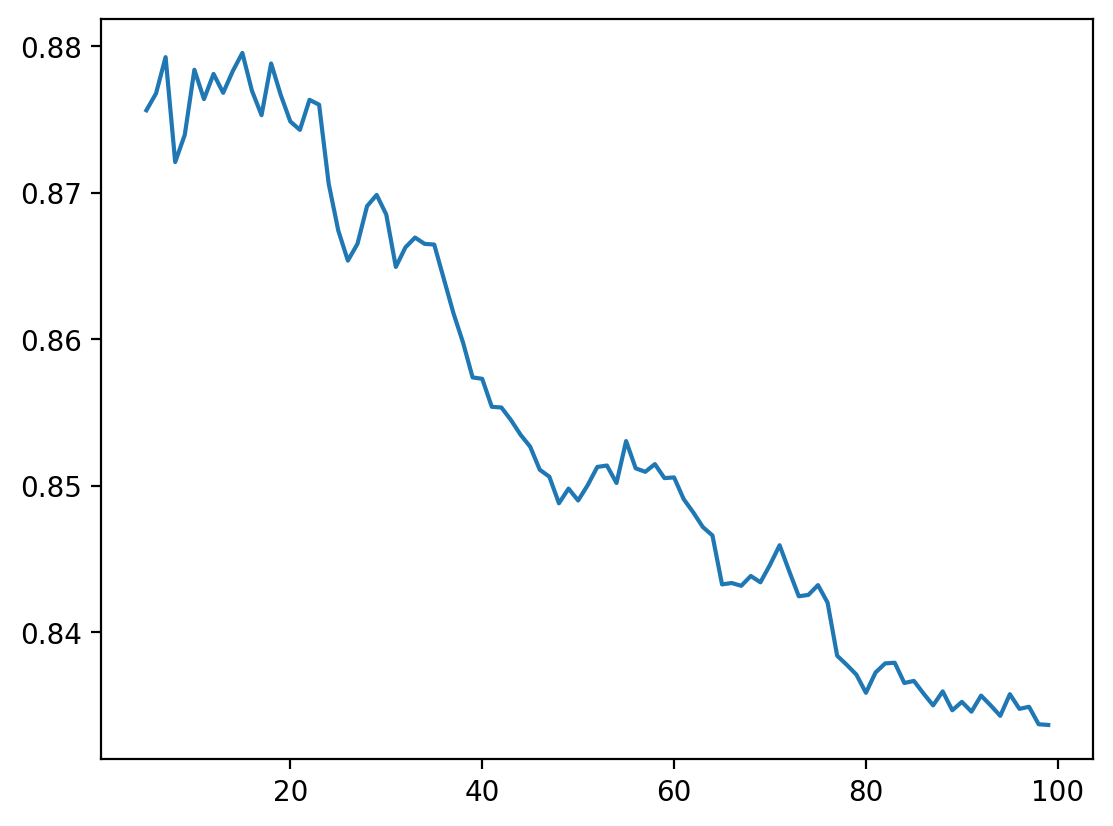

In [5]:
from past1000.compare import compare_corr_2d
from past1000.filters import calc_std_deviation

windows = np.arange(2, 100)
min_periods = np.repeat(2, 98)

rs, ps, ns = compare_corr_2d(
    model.historical_mean,
    model.climate_series,
    windows=windows,
    min_periods=min_periods,
    filter_func=calc_std_deviation,
    corr_method="kendall",
    filter_side="both",
)
plt.plot(windows, rs)

In [6]:
def generate_last_column_by_classified(
    df, value_col="value", expect_col="expect", classify_col="classified"
):
    """
    生成 last 列：上一次 classified 等级与当前相同的 expect 的 value
    """
    df = df.copy()
    df["last"] = np.nan
    # 按 classified 分组，对每组的 expect 的 value shift
    for c in df[classify_col].unique():
        mask = df[classify_col] == c
        df.loc[mask, "last"] = df.loc[mask, value_col].shift(1)
    return df["last"]


def check_estimation(
    data: pd.DataFrame,
    value_col: str = "value",
    expect_col: str = "expect",
    classify_col: str = "classified",
):
    """找到 h_data 里在 classify 中被归类为同一个级别的值，对比相同索引"""
    data["exact"] = data[expect_col] == data[classify_col]
    data["last"] = generate_last_column_by_classified(
        data, value_col, expect_col, classify_col
    )
    data["diff"] = data[value_col] - data["last"]
    return data


def analyze_misclassification_pivot(
    df, expect_col="expect", classified_col="classified", diff_col="diff"
):
    """
    使用 pandas pivot_table 分析被错判组合的平均 diff
    """
    # 只选择被错判的行
    misclassified = df[~df["exact"]].copy()

    if len(misclassified) == 0:
        print("没有找到错判的数据")
        return pd.DataFrame()

    # 使用 pivot_table 创建矩阵
    pivot_matrix = pd.pivot_table(
        misclassified,
        values=diff_col,
        index=expect_col,
        columns=classified_col,
        aggfunc="mean",  # 计算平均值
        fill_value=np.nan,
    )

    return pivot_matrix


checked_estimation = check_estimation(model.estimation)
diff_pivot = analyze_misclassification_pivot(checked_estimation)
diff_pivot

classified,-2,-1,0,1,2
expect,,,,,
-2.0,NaN,-0.58869,NaN,NaN,NaN
-1.0,0.557496,NaN,-0.040828,NaN,NaN
0.0,NaN,NaN,NaN,-0.051707,NaN
1.0,NaN,NaN,NaN,NaN,-0.127183
2.0,NaN,NaN,NaN,0.313083,NaN


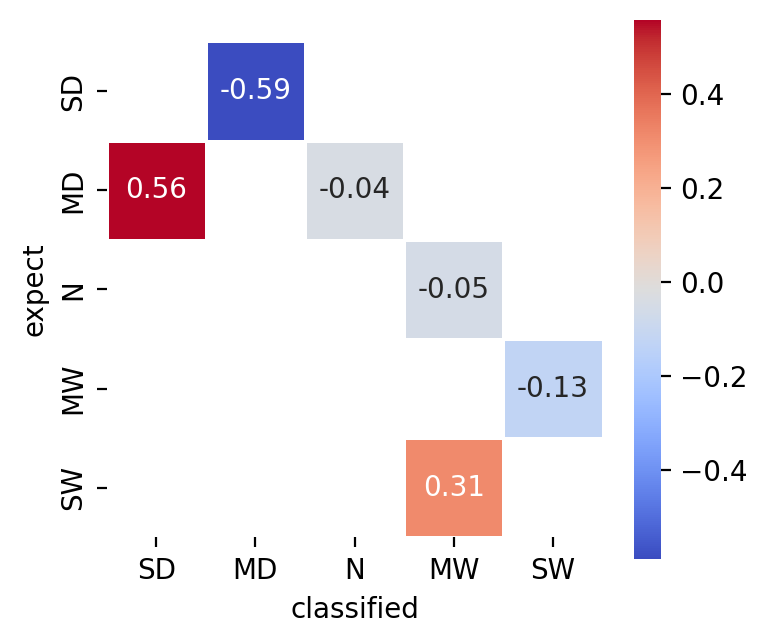

In [7]:
from past1000.viz.plot import TICK_LABELS
import seaborn as sns

fig, ax2 = plt.subplots(figsize=(4, 3.5))
sns.heatmap(
    diff_pivot,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    ax=ax2,
    linewidths=0.5,
)
ax2.set_xticklabels(TICK_LABELS)
ax2.set_yticklabels(TICK_LABELS)
plt.show();

## 读取模型结果

In [8]:
path = Path("../outputs/2025-06-20/23-14-28/correlations.csv")
df = pd.read_csv(path, index_col=0)
df.tail()

,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9
95,0.816575,0.835043,0.832804,0.781253,0.816881,0.823935,0.813528,0.814512,0.855676,0.832998
96,0.815294,0.835755,0.833231,0.781632,0.817308,0.823746,0.813434,0.813990,0.855345,0.832429
97,0.814962,0.835850,0.832994,0.781348,0.817355,0.823793,0.812675,0.812472,0.854965,0.832191
98,0.814250,0.836134,0.832282,0.781205,0.819015,0.823935,0.813291,0.811523,0.855582,0.832666
99,0.813681,0.836324,0.831855,0.781063,0.817877,0.823603,0.813623,0.811191,0.855866,0.832666


In [9]:
df.melt(ignore_index=False).reset_index()

,index,variable,value
0,2,model_0,NaN
1,3,model_0,NaN
2,4,model_0,NaN
3,5,model_0,NaN
4,6,model_0,NaN
...,...,...,...
975,95,model_9,0.832998
976,96,model_9,0.832429
977,97,model_9,0.832191
978,98,model_9,0.832666


<Axes: xlabel='index', ylabel='value'>

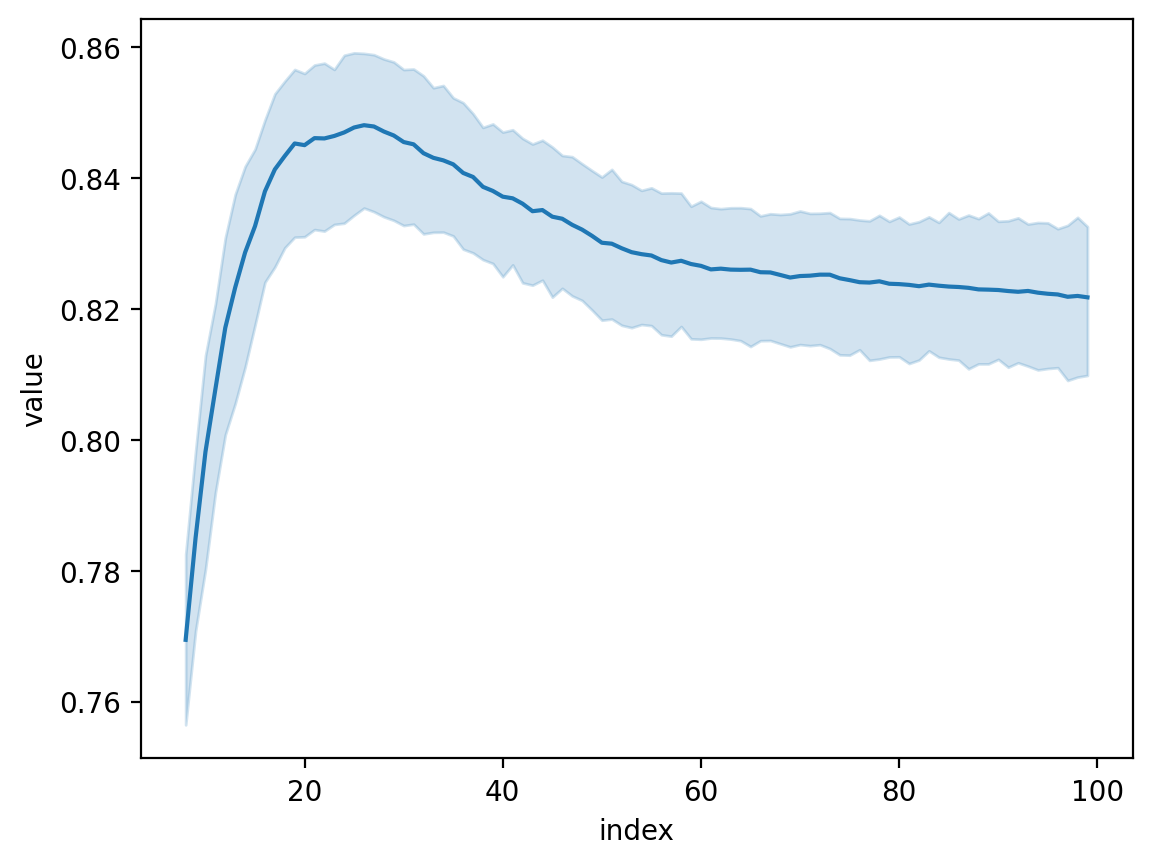

In [10]:
sns.lineplot(
    data=df.melt(ignore_index=False).reset_index(),
    x="index",
    y="value",
    # hue='variable',
)
plt.show()

In [11]:
path = Path("../multirun/2025-06-20/23-36-54")
datasets = []
for i in range(6):
    windows = 20 + i * 10
    df = pd.read_csv(path / f"{i}/correlations.csv", index_col=0)
    long = df.melt(ignore_index=False).reset_index()
    long["windows"] = windows
    datasets.append(long)

df = pd.concat(datasets, ignore_index=True)
df.head()

,index,variable,value,windows
0,2,model_0,NaN,20
1,3,model_0,NaN,20
2,4,model_0,NaN,20
3,5,model_0,NaN,20
4,6,model_0,NaN,20


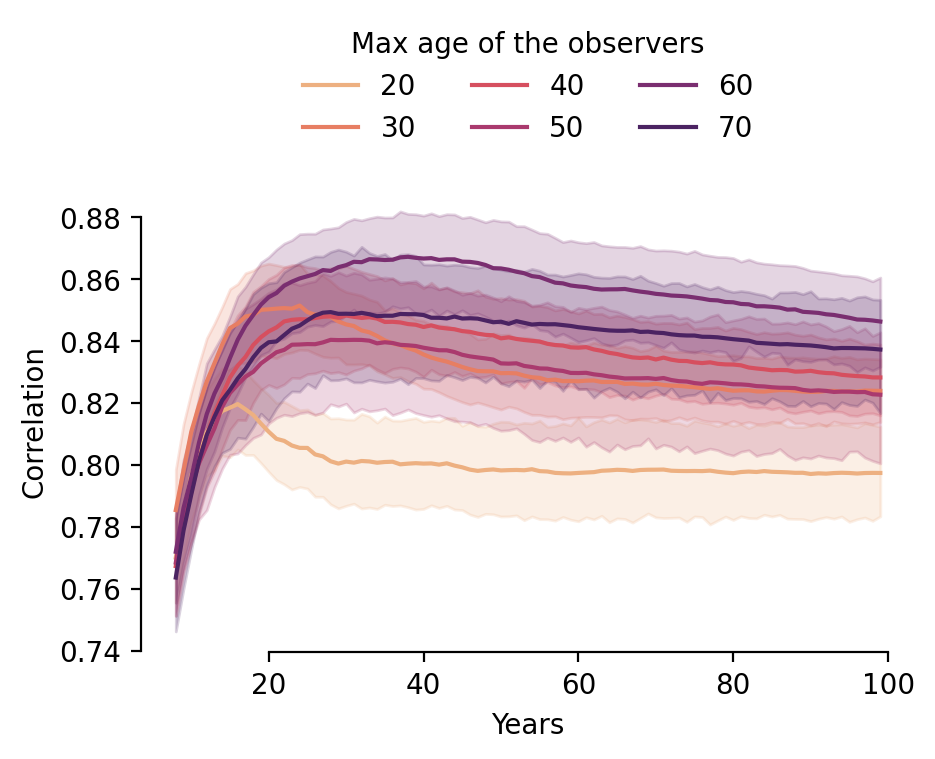

In [34]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(
    data=df,
    x="index",
    y="value",
    hue="windows",
    estimator=np.mean,
    palette="flare",
)
sns.despine(trim=True)
ax.set_xlabel("Years")
ax.set_ylabel("Correlation")
ax.legend(
    ncol=3,
    loc="lower center",
    bbox_to_anchor=(0.5, 1.05),
    frameon=False,
    title="Max age of the observers",
)
plt.show();

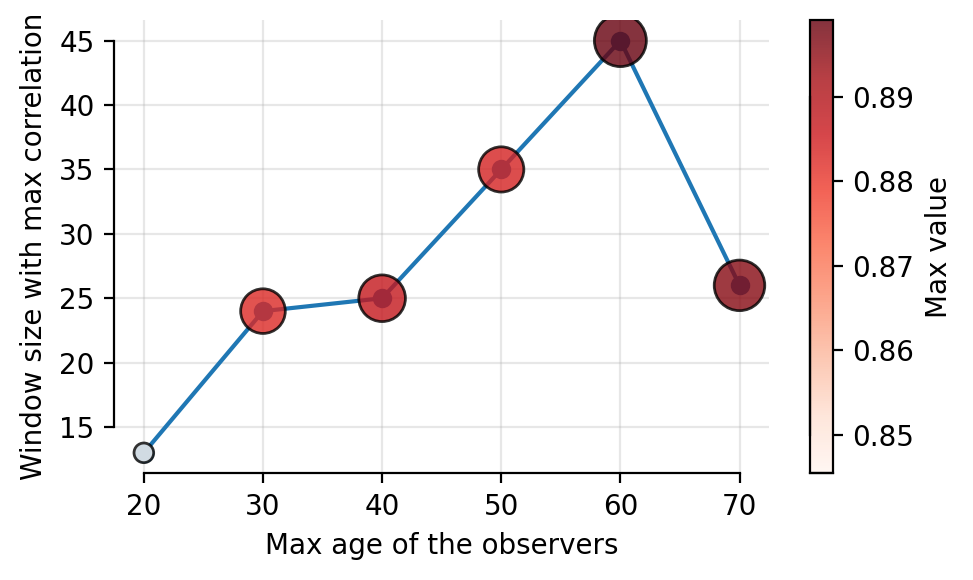

In [29]:
import matplotlib.pyplot as plt

# 找到每个windows下value最大的index和最大值
max_idx_df = df.loc[df.groupby("windows")["value"].idxmax()]
max_idx_df = max_idx_df.sort_values("windows")

plt.figure(figsize=(5, 3))
plt.scatter(
    max_idx_df["windows"],
    max_idx_df["index"],
    s=300
    * (max_idx_df["value"] - max_idx_df["value"].min())
    / (max_idx_df["value"].max() - max_idx_df["value"].min())
    + 50,  # 气泡大小归一化
    c=max_idx_df["value"],
    cmap="Reds",
    alpha=0.8,
    edgecolors="k",
    label="Max value index",
    zorder=100,
)
plt.plot(
    max_idx_df["windows"],
    max_idx_df["index"],
    marker="o",
    label="Maximum value position",
    zorder=10,
)
# for _, row in max_idx_df.iterrows():
#     plt.text(row['windows'], row['index']+1, f"{row['value']:.2f}", ha='center', va='bottom', fontsize=9)

plt.xlabel("Max age of the observers")
plt.ylabel("Window size with max correlation")
# plt.title('Index of Maximum Value for Each Window\n(Bubble size = max value)')
plt.colorbar(label="Max value")
plt.grid(True, alpha=0.3)
plt.tight_layout()
sns.despine(trim=True)
plt.show();

<Figure size 600x400 with 0 Axes>

Text(0.5, 0, 'diff')

Text(0, 0.5, 'prob_to_adjust')

Text(0.5, 1.0, 'Sigmoid function\n$prob = 1/(1+e^{-|diff|})$')

(0.0, 1.05)

(-6.0, 6.0)

Text(0, 0.4, 'sigmoid(0)=0.5')

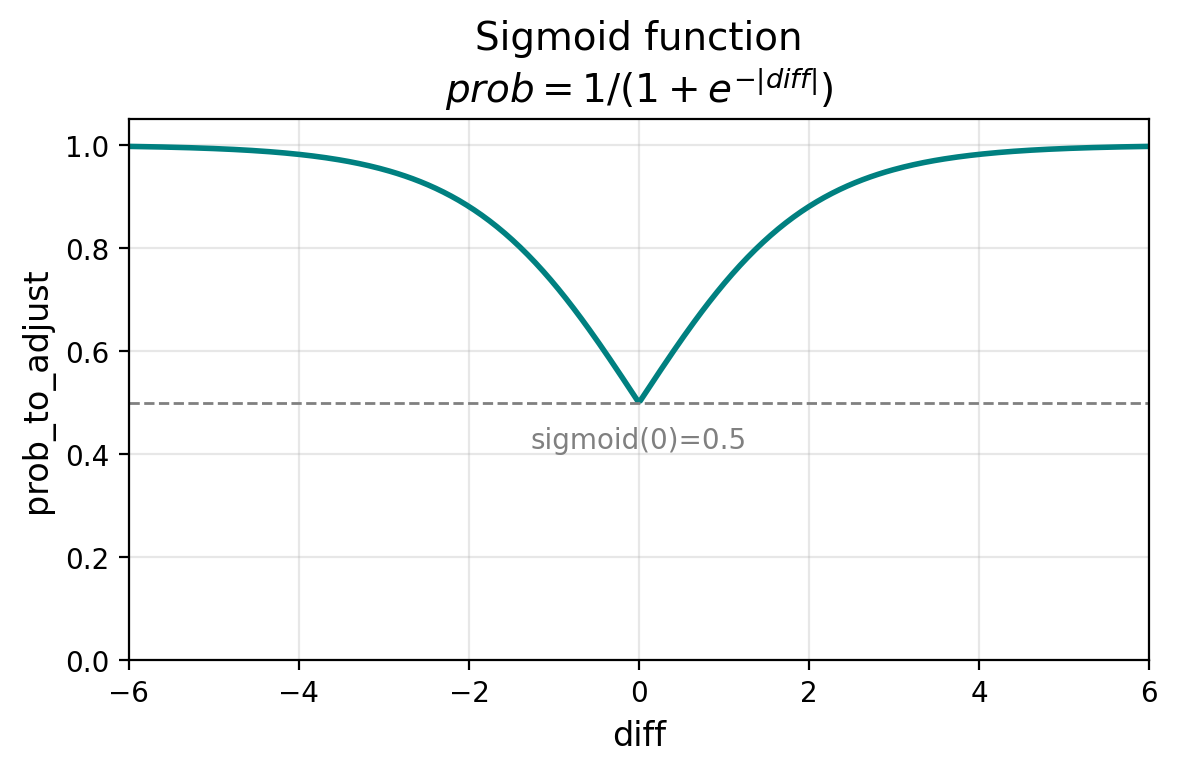

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 定义 diff 范围
diff = np.linspace(-6, 6, 400)
prob_to_adjust = 1 / (1 + np.exp(-np.abs(diff)))

plt.figure(figsize=(6, 4))
plt.plot(diff, prob_to_adjust, color="teal", lw=2)
plt.xlabel("diff", fontsize=12)
plt.ylabel("prob_to_adjust", fontsize=12)
plt.title("Sigmoid function\n$prob = 1/(1+e^{-|diff|})$", fontsize=14)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)
plt.xlim(-6, 6)
plt.axhline(0.5, color="gray", linestyle="--", lw=1)
plt.text(0, 0.40, "sigmoid(0)=0.5", ha="center", va="bottom", fontsize=10, color="gray")
plt.tight_layout()
plt.show()

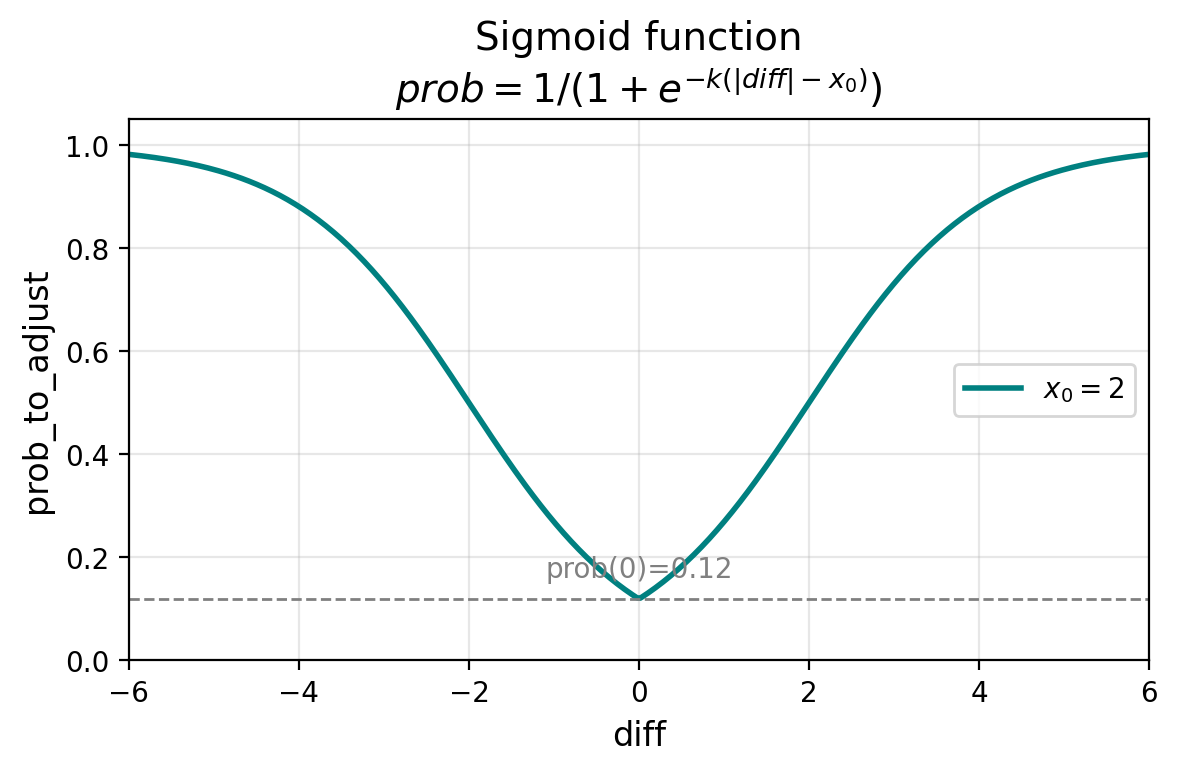

In [14]:
import numpy as np
import matplotlib.pyplot as plt

diff = np.linspace(-6, 6, 400)
k = 1
x0 = 2  # 控制diff=0时的概率
prob_to_adjust = 1 / (1 + np.exp(-k * (np.abs(diff) - x0)))

plt.figure(figsize=(6, 4))
plt.plot(diff, prob_to_adjust, color="teal", lw=2, label=f"$x_0={x0}$")
plt.xlabel("diff", fontsize=12)
plt.ylabel("prob_to_adjust", fontsize=12)
plt.title("Sigmoid function\n$prob = 1/(1+e^{-k(|diff|-x_0)})$", fontsize=14)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)
plt.xlim(-6, 6)
plt.axhline(1 / (1 + np.exp(k * x0)), color="gray", linestyle="--", lw=1)
plt.text(
    0,
    1 / (1 + np.exp(k * x0)) + 0.03,
    f"prob(0)={1/(1+np.exp(k*x0)):.2f}",
    ha="center",
    va="bottom",
    fontsize=10,
    color="gray",
)
plt.legend()
plt.tight_layout()
plt.show();